In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn, funksvd
from lenskit.algorithms import user_knn, tf, basic

from lenskit import topn

In [2]:
import pandas as pd

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv("./dataset/vlog_dataset.csv")
print( df.head() )

print( len(pd.unique(df['user_id'])) )
print( len(pd.unique(df['vlog_id'])) )

   user_id gender  age     country  vlog_id        tag  time_spent  like  \
0    32396      F   79     Reunion    93345  Skin Care          20     0   
1    15230      M   41    Thailand    93337    Fashion          10     1   
2    15230      M   41    Thailand     3619     Health           2     1   
3    78879      M   24      Serbia    23675     Travel           3     0   
4    26912      M   75  Guadeloupe    32326     Movies          16     0   

   comment  save  
0        1     0  
1        1     1  
2        1     0  
3        1     0  
4        1     1  
39497
63172


In [6]:
Bias = basic.Bias(damping=5)
Pop = basic.Popular()
II = item_knn.ItemItem(20, save_nbrs=1000)
UU = user_knn.UserUser(40)
ALS = als.BiasedMF(60)
IALS = als.ImplicitMF(60)
BPR = tf.BPR(50)
SVD = funksvd.FunkSVD(60, lrate = 0.0005)
TFMF = tf.IntegratedBiasMF(60)

In [7]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 50)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [8]:
df = df.rename(columns={'user_id': 'user', 'vlog_id': 'item'})

result = []
for i in range(0, df.shape[0]) : 
    result.append(5*df['like'][i] + df['comment'][i] + 4*df['save'][i])

df['rating'] = result

all_recs = []
test_data = []
for train, test in xf.partition_users(df, 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('FunkSVD', SVD, train, test))
    all_recs.append(eval('UserUser', UU, train, test))
    all_recs.append(eval('BasicPopular', Pop, train, test))
    all_recs.append(eval('BPR', BPR, train, test))
    all_recs.append(eval('TFMF', TFMF, train, test))
    all_recs.append(eval('IALS', IALS, train, test))

Epoch 1/5
10/10 [==============================] - 1s 44ms/step - loss: 0.6982
Epoch 2/5
10/10 [==============================] - 0s 48ms/step - loss: 0.6961
Epoch 3/5
10/10 [==============================] - 0s 47ms/step - loss: 0.6938
Epoch 4/5
10/10 [==============================] - 0s 45ms/step - loss: 0.6915
Epoch 5/5
10/10 [==============================] - 0s 46ms/step - loss: 0.6889
Epoch 1/5
10/10 [==============================] - 1s 48ms/step - loss: 10.5878
Epoch 2/5
10/10 [==============================] - 1s 55ms/step - loss: 10.4333
Epoch 3/5
10/10 [==============================] - 0s 48ms/step - loss: 10.4130
Epoch 4/5
10/10 [==============================] - 1s 51ms/step - loss: 10.3576
Epoch 5/5
10/10 [==============================] - 1s 51ms/step - loss: 10.2530
Epoch 1/5
10/10 [==============================] - 1s 44ms/step - loss: 0.6982
Epoch 2/5
10/10 [==============================] - 1s 52ms/step - loss: 0.6962
Epoch 3/5
10/10 [==============================

In [9]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,43031,7.985632,39,1,FunkSVD
1,66599,7.912968,39,2,FunkSVD
2,41083,7.832272,39,3,FunkSVD
3,66694,7.820243,39,4,FunkSVD
4,67529,7.695319,39,5,FunkSVD


In [10]:
test_data = pd.concat(test_data, ignore_index=True)

In [11]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs  ndcg
Algorithm user             
BPR       6      50.0   NaN
          31     50.0   0.0
          36     50.0   0.0
          39     50.0   0.0
          45     50.0   0.0

In [12]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
BPR             0.000093
BasicPopular    0.000083
FunkSVD         0.000132
IALS            0.000123
TFMF            0.000056
UserUser        0.000022
Name: ndcg, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

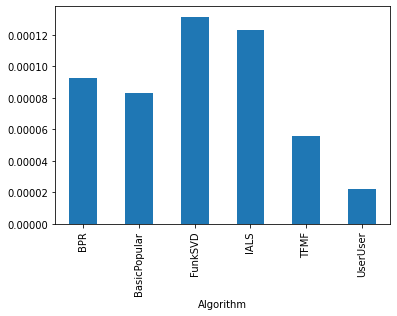

In [13]:
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [ ]:
# this is a prototype of how everything on a small scale could look like